In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"krishnakhemanth","key":"61b809846f4f16cfb81f30cfc7184948"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d dansbecker/food-101


Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
100% 9.37G/9.38G [01:34<00:00, 74.7MB/s]
100% 9.38G/9.38G [01:34<00:00, 106MB/s] 


In [5]:
!unzip food-101.zip -d /content/food-101


Streaming output truncated to the last 5000 lines.
  inflating: /content/food-101/food-101/food-101/images/tacos/1030289.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1033196.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1036030.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1042175.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1044043.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1058697.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1059239.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1059326.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1066762.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1070967.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1073468.jpg  
  inflating: /content/food-101/food-101/food-101/images/tacos/1075296.jpg  
  inflating: /content/food-101/food-1

In [6]:
!ls /content/food-101


food-101  food-101.zip


In [7]:
# Importing necessary libraries
import os
import torch
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from PIL import Image
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import requests as reqs
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from torch.utils.checkpoint import checkpoint
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import torch.utils.checkpoint as checkpoint
from albumentations.pytorch import ToTensorV2
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
import zipfile
import urllib.request
import shutil
import random
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# Setting the device for PyTorch; use CUDA if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [10]:
# Reading class name and creating a list of first 20 classes plus an 'other' class
classes = open("/content/food-101/food-101/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

# Defining a custom label encoder for the classes
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}
    def get_label(self, idx):
        return list(self.labels.keys())[idx]
    def get_idx(self, label):
        return self.labels.get(label)

# Initializing label encoder with 21 classes and testing its functionality
encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder_21.get_idx( encoder_21.get_label(0) )

# Printing each class with its corresponding index
for i in range(21):
    print(encoder_21.get_label(i), encoder_21.get_idx( encoder_21.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19
other 20


In [11]:
# Defining a custom dataset class for handling image data
class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        image = np.array(image)  # Convert to NumPy array for Albumentations

        label = encoder_21.get_idx(self.dataframe.label.iloc[idx])

        # Apply Albumentations transforms if available
        if self.transform:
            augmented = self.transform(image=image)  # Pass image as named argument
            image = augmented["image"]

        return image, label

In [25]:
from sklearn.utils import shuffle
import os
import numpy as np
import pandas as pd

def prep_df(path: str) -> pd.DataFrame:
    # Reading file and constructing full paths
    array = open(path, 'r').read().splitlines()
    img_path = "/content/food-101/food-101/food-101/images"
    full_path = [os.path.join(img_path, img + ".jpg") for img in array]

    # Splitting the image paths into labels and indices
    labels_indices = [img.split('/') for img in array]
    labels_indices = np.array(labels_indices)

    # Adjusting labels using encoder_21
    for idx, img in enumerate(labels_indices):
        if encoder_21.get_idx(img[0]) is None:
            labels_indices[idx, 0] = "other"  # Assign 'other' for unmatched labels

    # Creating the DataFrame
    imgs = pd.DataFrame({
        "label": labels_indices[:, 0],
        "image_index": labels_indices[:, 1],
        "path": full_path
    })

    # Shuffling the DataFrame
    imgs = shuffle(imgs).reset_index(drop=True)
    return imgs

# Preparing training and testing DataFrames
train_imgs = prep_df('/content/food-101/food-101/food-101/meta/train.txt')
test_imgs = prep_df('/content/food-101/food-101/food-101/meta/test.txt')

# Printing the count of images per label in the training set
print(train_imgs.groupby(["label"]).count())


                    image_index   path
label                                 
apple_pie                   750    750
baby_back_ribs              750    750
baklava                     750    750
beef_carpaccio              750    750
beef_tartare                750    750
beet_salad                  750    750
beignets                    750    750
bibimbap                    750    750
bread_pudding               750    750
breakfast_burrito           750    750
bruschetta                  750    750
caesar_salad                750    750
cannoli                     750    750
caprese_salad               750    750
carrot_cake                 750    750
ceviche                     750    750
cheese_plate                750    750
cheesecake                  750    750
chicken_curry               750    750
chicken_quesadilla          750    750
other                     60750  60750


In [26]:
train_imgs = prep_df('/content/food-101/food-101/food-101/meta/train.txt')
test_imgs = prep_df('/content/food-101/food-101/food-101/meta/test.txt')

train_imgs.head(5)

,label,image_index,path
0,other,2928322,/content/food-101/food-101/food-101/images/red...
1,other,3065857,/content/food-101/food-101/food-101/images/ram...
2,other,3354880,/content/food-101/food-101/food-101/images/lob...
3,other,979057,/content/food-101/food-101/food-101/images/gre...
4,other,1384634,/content/food-101/food-101/food-101/images/fri...


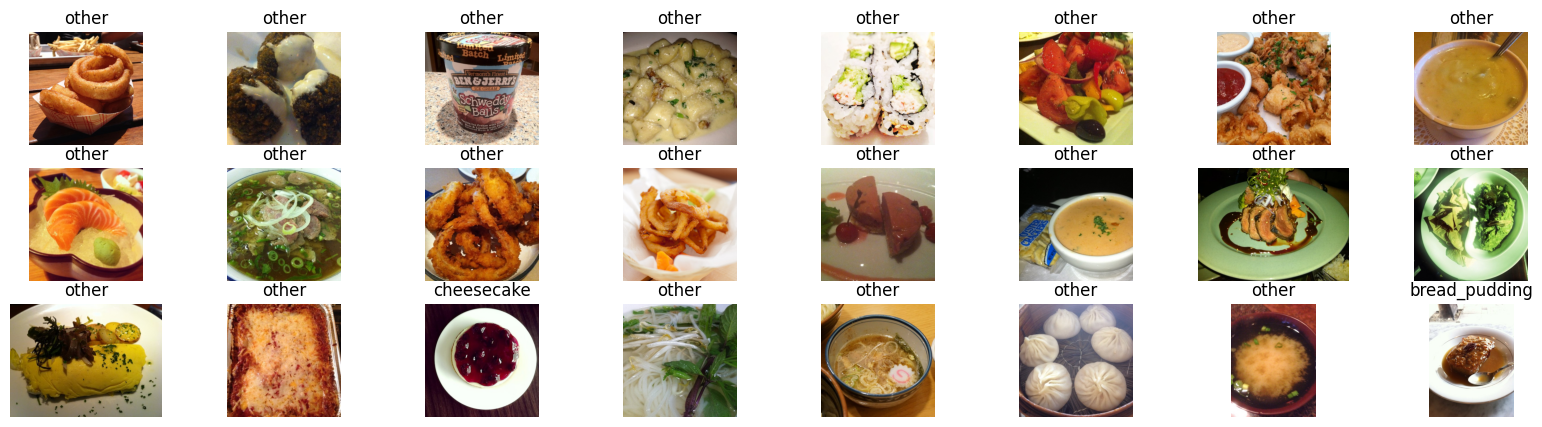

In [27]:
plt.figure(figsize=(20, 5))
num_rows = 3
num_cols = 8

for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])
    label = train_imgs.label.iloc[random_idx]
    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [28]:
# Define the directory where you want to save the zip file and extracted content
download_dir = '/content'
extracted_dir = '/content/food-101'

# URL for the Food101 dataset zip file
dataset_url = "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz"
dataset_zip_path = os.path.join(download_dir, 'food-101.tar.gz')

# Download the dataset
print("Downloading the Food101 dataset...")
urllib.request.urlretrieve(dataset_url, dataset_zip_path)
print("Download completed")

# Extract the tar.gz file
import tarfile

print("Extracting the dataset...")
with tarfile.open(dataset_zip_path, 'r:gz') as tar:
    tar.extractall(path=extracted_dir)
print(f"Extraction completed")


Download completed
Extracting the dataset...
Extraction completed


In [29]:
# Path to the original Food101 dataset
original_dataset_dir = '/content/food-101/food-101/food-101/images'  # Replace with the path to your dataset

selected_classes = [
    "apple_pie", "baby_back_ribs", "baklava", "beef_carpaccio", "beef_tartare",
    "beet_salad", "beignets", "bibimbap", "bread_pudding", "breakfast_burrito",
    "bruschetta", "caesar_salad", "cannoli", "caprese_salad", "carrot_cake",
    "ceviche", "cheesecake", "cheese_plate", "chicken_curry", "chicken_quesadilla"
]

# Create a mapping of class names to indices
class_to_idx = {cls: idx for idx, cls in enumerate(selected_classes)}
class_to_idx["other"] = -1  # Label for the "other" category

# Directory for the filtered dataset
filtered_dataset_dir = '/content/food21'
train_dir = os.path.join(filtered_dataset_dir, "train")
test_dir = os.path.join(filtered_dataset_dir, "test")
train_labels_file = os.path.join(filtered_dataset_dir, "train_labels.txt")
test_labels_file = os.path.join(filtered_dataset_dir, "test_labels.txt")

# Create the train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create directories for selected classes and the "other" category
for class_name in selected_classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

os.makedirs(os.path.join(train_dir, "other"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "other"), exist_ok=True)


In [30]:
# Function to copy images and write labels to the new dataset structure
def copy_images_and_assign_labels(src_folder, train_ratio=0.7):
    with open(train_labels_file, 'w') as train_labels, open(test_labels_file, 'w') as test_labels:
        for class_name in tqdm(os.listdir(src_folder)):
            class_path = os.path.join(src_folder, class_name)
            if not os.path.isdir(class_path):
                continue

            images = os.listdir(class_path)
            random.shuffle(images)

            # Calculate split index for train and test
            split_index = int(len(images) * train_ratio)
            train_images = images[:split_index]
            test_images = images[split_index:]

            dst_class_folder = class_name if class_name in selected_classes else "other"
            label = class_to_idx.get(class_name, -1)

            for image_name in train_images:
                src_image_path = os.path.join(class_path, image_name)
                dst_image_path = os.path.join(train_dir, dst_class_folder, image_name)
                shutil.copy2(src_image_path, dst_image_path)
                train_labels.write(f"{dst_class_folder}/{image_name} {label}\n")

            for image_name in test_images:
                src_image_path = os.path.join(class_path, image_name)
                dst_image_path = os.path.join(test_dir, dst_class_folder, image_name)
                shutil.copy2(src_image_path, dst_image_path)
                test_labels.write(f"{dst_class_folder}/{image_name} {label}\n")

copy_images_and_assign_labels(original_dataset_dir)

100%|██████████| 102/102 [02:20<00:00,  1.38s/it]


In [31]:
class_labels = [
    "apple_pie", "baby_back_ribs", "baklava", "beef_carpaccio", "beef_tartare",
    "beet_salad", "beignets", "bibimbap", "bread_pudding", "breakfast_burrito",
    "bruschetta", "caesar_salad", "cannoli", "caprese_salad", "carrot_cake",
    "ceviche", "cheesecake", "cheese_plate", "chicken_curry", "chicken_quesadilla",
    "other"
]
num_classes = len(class_labels)

In [32]:
# Cutout Augmentation
class CutOut(object):
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask
        return img

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    CutOut(n_holes=1, length=16)
])

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dir = '/content/food21/train'
test_dir = '/content/food21/test'

trainset = datasets.ImageFolder(root=train_dir, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)

testset = datasets.ImageFolder(root=test_dir, transform=transform_test)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [33]:
#  Gradient Checkpointing
class CheckpointedResNet152(nn.Module):
    def __init__(self, num_classes=21):
        super(CheckpointedResNet152, self).__init__()
        base_model = models.resnet152(weights='IMAGENET1K_V1')

        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool

        self.layer1 = base_model.layer1
        self.layer2 = base_model.layer2
        self.layer3 = base_model.layer3
        self.layer4 = base_model.layer4

        self.avgpool = base_model.avgpool
        self.fc = nn.Linear(base_model.fc.in_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = checkpoint.checkpoint_sequential(self.layer1, segments=1, input=x)
        x = checkpoint.checkpoint_sequential(self.layer2, segments=1, input=x)
        x = checkpoint.checkpoint_sequential(self.layer3, segments=1, input=x)
        x = checkpoint.checkpoint_sequential(self.layer4, segments=1, input=x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [37]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR

# Assuming you have uploaded the weights file to your Colab environment
weights_path = '/content/food21'  # Update with the correct path

# Model Initialization
model = CheckpointedResNet152(num_classes=num_classes).to(device)

# Load custom weights
try:
    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device), strict=False)
        print("Custom weights loaded successfully.")
    else:
        raise FileNotFoundError(f"Weights file not found at {weights_path}")
except Exception as e:
    print(f"Failed to load custom weights: {e}")

# Optimizer, criterion, and scheduler setup
scaler = torch.cuda.amp.GradScaler()  # Corrected method name
model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=5e-4)

warmup_epochs = 6
total_epochs = 15
scheduler = SequentialLR(
    optimizer,
    schedulers=[
        LinearLR(optimizer, start_factor=0.1, total_iters=warmup_epochs),
        CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)
    ],
    milestones=[warmup_epochs]
)


Failed to load custom weights: [Errno 21] Is a directory: '/content/food21'


<ipython-input-37-1b1132ef41e0>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=device), strict=False)
<ipython

In [38]:
def train(epoch):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, targets in tqdm(trainloader, desc=f"Training Epoch {epoch + 1}"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():  # Mixed Precision
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += predicted.eq(targets).sum().item()

    train_accuracy = 100. * correct_train / total_train
    print(f'Training Loss: {running_loss/len(trainloader):.3f} | Training Accuracy: {train_accuracy:.2f}%')

def test(epoch):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, targets in tqdm(testloader, desc=f"Testing Epoch {epoch + 1}"):
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.cuda.amp.autocast():  # Mixed Precision
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    test_accuracy = 100. * correct_test / total_test
    print(f' Epoch {epoch + 1}: {test_accuracy:.2f}%')
    return test_accuracy

In [2]:
best_accuracy = 0.0

for epoch in range(1):
    train(epoch)
    accuracy = test(epoch)
    scheduler.step()

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), 'best_resnet152_food21.pt')
        print(f"Best model saved with accuracy: {best_accuracy:.2f}%")

print("Training completed.")

NameError: name 'train' is not defined

In [1]:
def evaluate_final_accuracy(model, testloader):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, targets in tqdm(testloader, desc="Evaluating Final Accuracy"):
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.cuda.amp.autocast():  # Mixed Precision
                outputs = model(inputs)
            _, predicted = outputs.max(1)
            total_test += targets.size(0)
            correct_test += predicted.eq(targets).sum().item()

    final_accuracy = 100. * correct_test / total_test
    print(f'Final Test Accuracy: {final_accuracy:.2f}%')
    return final_accuracy

# Call this function after the training loop
final_accuracy = evaluate_final_accuracy(model, testloader)


NameError: name 'model' is not defined